In [4]:
! pip install tensorflow

Epoch 0, D Loss: 0.6900, G Loss: 0.6617
Epoch 100, D Loss: 0.6387, G Loss: 0.3953
Epoch 200, D Loss: 0.6427, G Loss: 0.6719
Epoch 300, D Loss: 0.6398, G Loss: 0.6593
Epoch 400, D Loss: 0.6356, G Loss: 0.7892
Epoch 500, D Loss: 0.6579, G Loss: 0.6315
Epoch 600, D Loss: 0.6390, G Loss: 0.7125
Epoch 700, D Loss: 0.6396, G Loss: 0.7419
Epoch 800, D Loss: 0.6491, G Loss: 0.7426
Epoch 900, D Loss: 0.6521, G Loss: 0.7561
Epoch 1000, D Loss: 0.6483, G Loss: 0.7788
Epoch 1100, D Loss: 0.6518, G Loss: 0.7640
Epoch 1200, D Loss: 0.6308, G Loss: 0.7918
Epoch 1300, D Loss: 0.6302, G Loss: 0.8330
Epoch 1400, D Loss: 0.6319, G Loss: 0.7907
Epoch 1500, D Loss: 0.6457, G Loss: 0.8027
Epoch 1600, D Loss: 0.5861, G Loss: 0.8414
Epoch 1700, D Loss: 0.5778, G Loss: 0.8142
Epoch 1800, D Loss: 0.6089, G Loss: 0.8219
Epoch 1900, D Loss: 0.6139, G Loss: 0.7964
Number of anomalies detected: 26
Sample anomalies detected (first 5 samples):
[[-0.73333287  0.91759516 -0.40940214  6.43046461 -0.8624872 ]
 [-0.073074

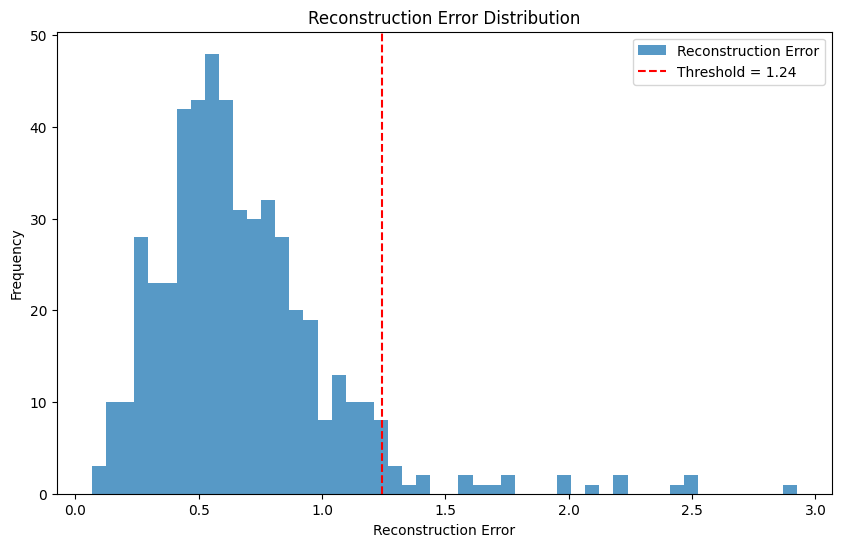

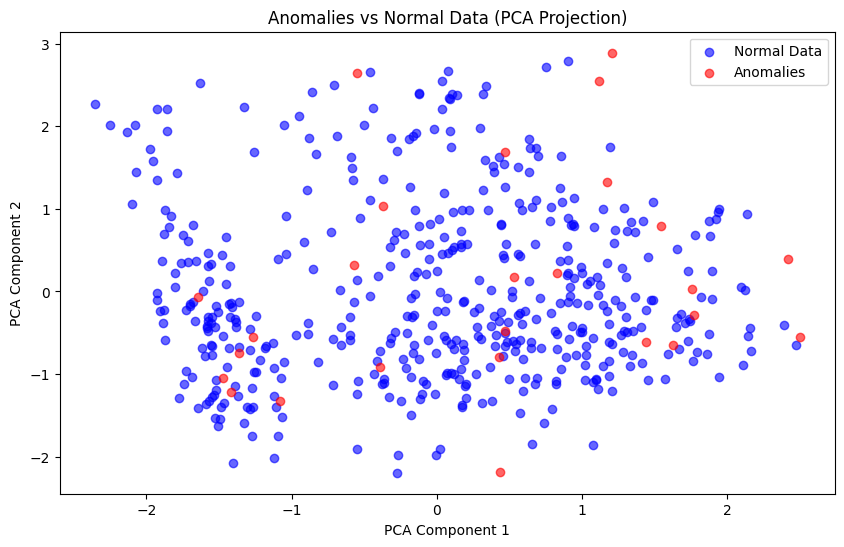

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load and preprocess data
data = pd.read_csv('transaction.csv')
data = data.select_dtypes(include=[np.number]).fillna(0)
data = (data - data.mean()) / data.std()  # Normalize data
data = data.values

# Split into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        BatchNormalization(),
        LeakyReLU(0.2),
        Dense(256),
        BatchNormalization(),
        LeakyReLU(0.2),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(128),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = train_data.shape[1]

# Build models
generator = build_generator(input_dim, input_dim)
discriminator = build_discriminator(input_dim)

# Compile discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy', metrics=['accuracy'])

# GAN
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Training parameters
epochs = 2000
batch_size = 64

@tf.function
def generate_fake_data(generator, noise):
    return generator(noise, training=False)

@tf.function
def reconstruct_data(generator, data):
    return generator(data, training=False)

# Training loop
for epoch in range(epochs):
    # Select a random batch of real data
    idx = np.random.randint(0, train_data.shape[0], batch_size)
    real_data = train_data[idx]

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generate_fake_data(generator, noise)

    # Train discriminator
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))[0]
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))[0]
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # Train generator
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Anomaly detection
reconstructed = reconstruct_data(generator, test_data)
reconstruction_error = np.mean(np.abs(test_data - reconstructed), axis=1)
threshold = np.percentile(reconstruction_error, 95)

# Get the anomalies
anomalies = test_data[reconstruction_error > threshold]

# Print number of anomalies
print(f"Number of anomalies detected: {len(anomalies)}")

# Show a preview of anomalies
print("Sample anomalies detected (first 5 samples):")
print(anomalies[:5])  # Shows the first 5 anomaly samples

# Optionally, you can save the anomalies to a CSV file
anomalies_df = pd.DataFrame(anomalies)
anomalies_df.to_csv('detected_anomalies.csv', index=False)
print("Anomalies have been saved to 'detected_anomalies.csv'.")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75, label="Reconstruction Error")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

# PCA for anomaly visualization
pca = PCA(n_components=2)
test_data_2d = pca.fit_transform(test_data)

# Labels for anomalies and normal data
labels = np.where(reconstruction_error > threshold, 1, 0)  # 1: Anomaly, 0: Normal
normal_data = test_data_2d[labels == 0]
anomalous_data = test_data_2d[labels == 1]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(normal_data[:, 0], normal_data[:, 1], alpha=0.6, label="Normal Data", c="blue")
plt.scatter(anomalous_data[:, 0], anomalous_data[:, 1], alpha=0.6, label="Anomalies", c="red")
plt.title("Anomalies vs Normal Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()